In [3]:
import pandas as pd
import numpy as np
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.metrics import mean_squared_error
import scipy.stats as st

# Prepare data

In [7]:
# Read in UK data
df_uk = pd.read_csv('../data/UK_consolidated_df.csv')

# First difference inflation rate
df_uk['infl_rate_diff'] = df_uk['infl_rate'].diff()
df_uk['ppi_diff'] = df_uk['ppi'].diff()

# Drop rows with missing values due to differencing
df_uk = df_uk.dropna()

# Reorder columns
df_uk = df_uk[['date', 'infl_rate', 'infl_rate_diff', 'ppi_diff', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']]

df_uk

,date,infl_rate,infl_rate_diff,ppi_diff,gdp_pct_change,int_3m,cons_conf,unm_rate
1,1986-03-01,0.001035,-0.003123,0.000000,1.789575,11.77679,99.74067,11.2
2,1986-04-01,0.010341,0.009306,0.156641,1.219277,10.57670,99.80801,11.3
3,1986-05-01,0.001024,-0.009318,-0.234958,1.219277,10.26705,99.85727,11.3
4,1986-06-01,0.000000,-0.001024,0.078317,1.219277,9.82292,99.89935,11.3
5,1986-07-01,-0.003067,-0.003067,-0.078317,1.735118,10.03805,99.93089,11.3
...,...,...,...,...,...,...,...,...
462,2024-08-01,0.003762,0.004514,0.000000,1.364935,4.91000,101.52670,4.3
463,2024-09-01,0.000750,-0.003013,0.000000,1.364935,4.84000,101.45370,4.3
464,2024-10-01,0.005993,0.005243,0.000000,1.064721,4.75000,101.33200,4.4
465,2024-11-01,0.002234,-0.003759,0.000000,1.064721,4.68000,101.21320,4.4


In [8]:
# Read in US data
df_us = pd.read_csv('../data/US_consolidated_df.csv')
df_us

# First difference inflation rate
df_us['infl_rate_diff'] = df_us['infl_rate'].diff()
df_us['ppi_diff'] = df_us['ppi'].diff()

# Drop na values due to differencing
df_us = df_us.dropna()

# Reorder columns
df_us = df_us[['date', 'infl_rate', 'infl_rate_diff', 'ppi_diff', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']]

# Display df_us
df_us

,date,infl_rate,infl_rate_diff,ppi_diff,gdp_pct_change,int_3m,cons_conf,unm_rate
1,2003-06-01,0.001093,0.002731,1.300,1.240696,1.04,100.50950,6.3
2,2003-07-01,0.003277,0.002183,-0.300,2.244394,1.05,100.51170,6.2
3,2003-08-01,0.004355,0.001078,0.300,2.244394,1.08,100.42250,6.1
4,2003-09-01,0.003252,-0.001103,0.500,2.244394,1.08,100.38710,6.1
5,2003-10-01,-0.001080,-0.004333,0.800,1.777219,1.10,100.53510,6.0
...,...,...,...,...,...,...,...,...
257,2024-10-01,0.002265,-0.000027,0.399,1.173563,4.62,98.91297,4.1
258,2024-11-01,0.002805,0.000540,0.115,1.173563,4.53,98.91297,4.2
259,2024-12-01,0.003647,0.000842,0.210,1.173563,4.46,98.91297,4.1
260,2025-01-01,0.004669,0.001023,3.796,1.173563,4.33,98.91297,4.0


# First-Order Autoregressive Model

## Why use `infl_rate_diff` instead of `infl_rate`?

1. Stationarity:
    - Many time series, including inflation rates, exhibit trends or non-stationary behavior, meaning their statistical properties (mean, variance, etc.) change over time.
    - Differencing the series (e.g., calculating `infl_rate_diff`) helps remove trends and makes the series stationary, which is a key assumption for many statistical models, including autoregressive models.

2. Modeling Changes:
    - The first difference (`infl_rate_diff`) represents the change in the inflation rate from one period to the next. This is often more informative for understanding short-term dynamics and relationships between variables than the raw inflation rate.

3. Avoiding Spurious Relationships:
    - Non-stationary variables can lead to spurious regression results, where relationships appear significant due to shared trends rather than actual causal connections. Differencing helps mitigate this issue.

4. Focus on Dynamics:
    - Economic models often focus on how changes in variables (e.g., inflation rate changes) respond to other factors, rather than their absolute levels. Using `infl_rate_diff` aligns with this focus.

By using `infl_rate_diff`, we ensure that the data meets the assumptions of the statistical models and better captures the underlying dynamics of the inflation rate.

In [9]:
def adf_test(data, max_lag):
    adf = sm.tsa.adfuller(data, maxlag=max_lag)
    print(f'ADF Statistic: {round(adf[0], 4)}')
    print(f'p-value: {adf[1]}')
    for key, value in adf[4].items():
        print(f'Critial Values:   {key}, {round(value, 4)}')
    if adf[1] < 0.05:
        print('Reject the null hypothesis - data is stationary')
    else:
        print('Fail to reject the null hypothesis - data is non-stationary')

adf_test(df_uk['infl_rate_diff'], 0)
print()
adf_test(df_us['infl_rate_diff'], 0)

ADF Statistic: -35.1052
p-value: 0.0
Critial Values:   1%, -3.4445
Critial Values:   5%, -2.8678
Critial Values:   10%, -2.5701
Reject the null hypothesis - data is stationary

ADF Statistic: -18.0293
p-value: 2.6794757786386174e-30
Critial Values:   1%, -3.4558
Critial Values:   5%, -2.8727
Critial Values:   10%, -2.5727
Reject the null hypothesis - data is stationary


## UK

                            OLS Regression Results                            
Dep. Variable:         infl_rate_diff   R-squared:                       0.206
Model:                            OLS   Adj. R-squared:                  0.204
Method:                 Least Squares   F-statistic:                     120.0
Date:                Sat, 22 Mar 2025   Prob (F-statistic):           5.58e-25
Time:                        23:37:41   Log-Likelihood:                 1878.8
No. Observations:                 465   AIC:                            -3754.
Df Residuals:                     463   BIC:                            -3745.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                3.886e-06    

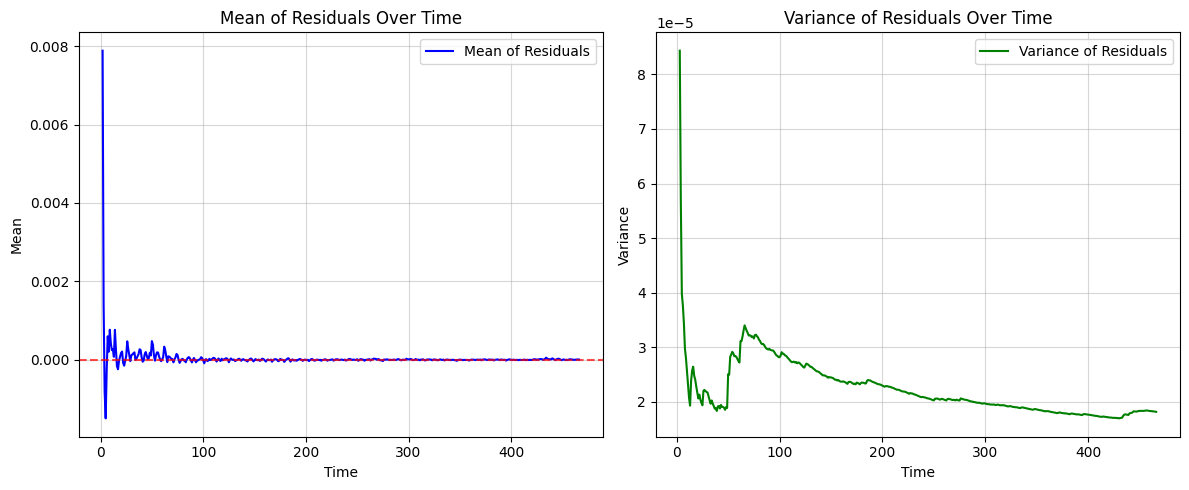

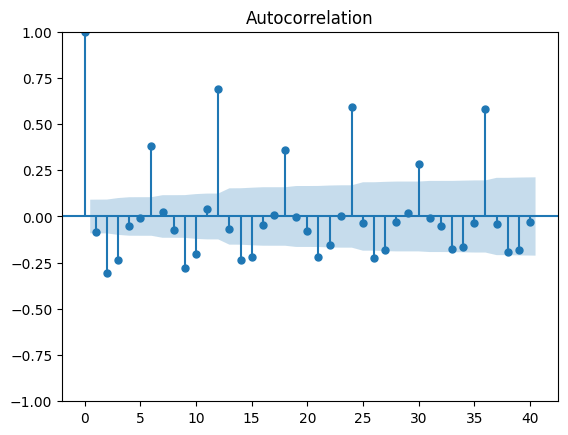

In [10]:
df_uk_ar1 = df_uk.copy()

# Create lagged variable for infl_rate_diff
df_uk_ar1['infl_rate_diff_lag1'] = df_uk_ar1['infl_rate_diff'].shift(1)

# Drop rows with NaN values due to lagging
df_uk_ar1 = df_uk_ar1.dropna(subset=['infl_rate_diff', 'infl_rate_diff_lag1'])

# Define dependent and independent variables
X = df_uk_ar1['infl_rate_diff_lag1']
y = df_uk_ar1['infl_rate_diff']

# Add constant to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

# Generate residuals
residuals = model.resid

# Compute moments (mean and variance) of residuals over time
mean_residuals = residuals.expanding().mean()
var_residuals = residuals.expanding().var()

# Plot the moments of residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot mean of residuals
ax[0].plot(mean_residuals, label='Mean of Residuals', color='blue')
ax[0].axhline(0, color='red', linestyle='--', alpha=0.7)
ax[0].set_title('Mean of Residuals Over Time')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Mean')
ax[0].legend()
ax[0].grid(alpha=0.5)

# Plot variance of residuals
ax[1].plot(var_residuals, label='Variance of Residuals', color='green')
ax[1].set_title('Variance of Residuals Over Time')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Variance')
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

# Plot ACF of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

## US

                            OLS Regression Results                            
Dep. Variable:         infl_rate_diff   R-squared:                       0.013
Model:                            OLS   Adj. R-squared:                  0.009
Method:                 Least Squares   F-statistic:                     3.448
Date:                Sat, 22 Mar 2025   Prob (F-statistic):             0.0645
Time:                        23:37:50   Log-Likelihood:                 1130.3
No. Observations:                 260   AIC:                            -2257.
Df Residuals:                     258   BIC:                            -2249.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                          coef    std err          t      P>|t|      [0.025      0.975]
---------------------------------------------------------------------------------------
const                6.884e-06    

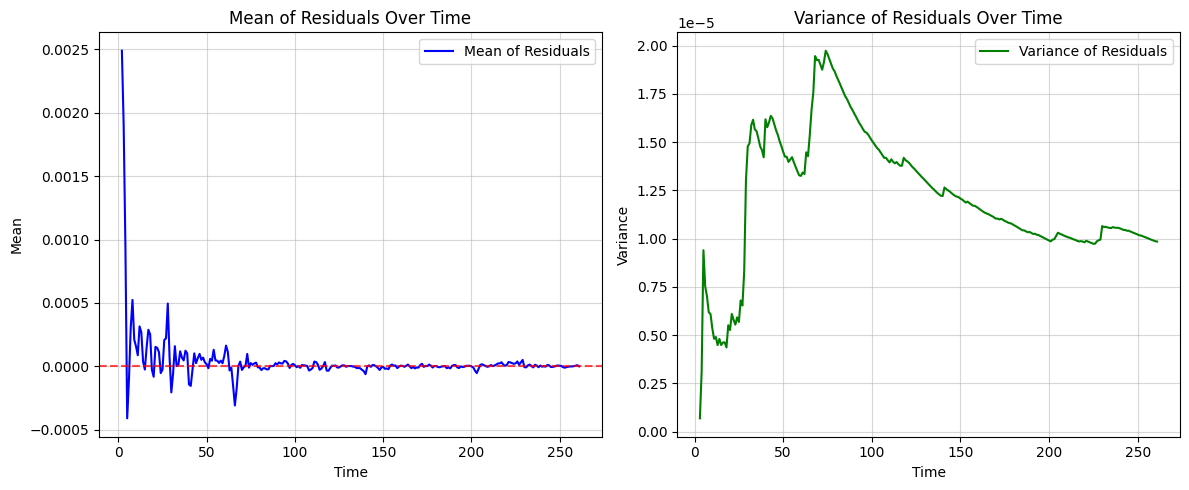

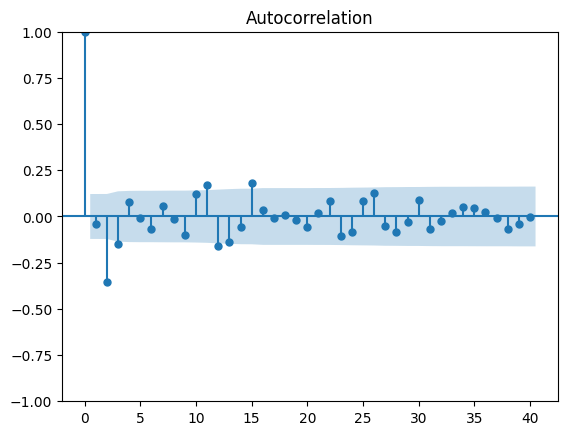

In [11]:
df_us_ar1 = df_us.copy()

# Create lagged variable for infl_rate_diff
df_us_ar1['infl_rate_diff_lag1'] = df_us_ar1['infl_rate_diff'].shift(1)

# Drop rows with NaN values due to lagging
df_us_ar1 = df_us_ar1.dropna(subset=['infl_rate_diff', 'infl_rate_diff_lag1'])

# Define dependent and independent variables
X = df_us_ar1['infl_rate_diff_lag1']
y = df_us_ar1['infl_rate_diff']

# Add constant to the independent variable
X = sm.add_constant(X)

# Fit the OLS model
model = sm.OLS(y, X).fit()

# Print the summary of the regression
print(model.summary())

# Generate residuals
residuals = model.resid

# Compute moments (mean and variance) of residuals over time
mean_residuals = residuals.expanding().mean()
var_residuals = residuals.expanding().var()

# Plot the moments of residuals
fig, ax = plt.subplots(1, 2, figsize=(12, 5))

# Plot mean of residuals
ax[0].plot(mean_residuals, label='Mean of Residuals', color='blue')
ax[0].axhline(0, color='red', linestyle='--', alpha=0.7)
ax[0].set_title('Mean of Residuals Over Time')
ax[0].set_xlabel('Time')
ax[0].set_ylabel('Mean')
ax[0].legend()
ax[0].grid(alpha=0.5)

# Plot variance of residuals
ax[1].plot(var_residuals, label='Variance of Residuals', color='green')
ax[1].set_title('Variance of Residuals Over Time')
ax[1].set_xlabel('Time')
ax[1].set_ylabel('Variance')
ax[1].legend()
ax[1].grid(alpha=0.5)

plt.tight_layout()
plt.show()

# Plot ACF of residuals
sm.graphics.tsa.plot_acf(residuals, lags=40)
plt.show()

## Is R² estimate relevant?

1. R² is designed for models with independent and identically distributed (IID) residuals.

2. In AR(1) models, the errors are autocorrelated as seen by significant spikes in the ACF plots of the residuals, meaning each error term depends on previous values, violating the IID assumption.

3. This can make R² misleading because a high R² doesn’t necessarily mean a good predictive fit in the presence of autocorrelation.

## Analysing moments

**Mean:**

A stationary model should have residuals with a mean close to 0 over time. 

If the mean deviates significantly from 0, it suggests that the model has a bias or is missing some key explanatory variables. For a well-specified model, the mean of residuals should hover around 0 without significant deviations. 

If the mean of residuals deviates significantly from 0, it suggests that the model is biased or that there are systematic patterns in the residuals that the model has not captured.

**Variance:**

A stationary model should have residuals with a constant variance over time (homoscedasticity). For a well-specified model, the variance of residuals should remain relatively constant over time. 

If the variance changes significantly, it indicates heteroscedasticity or instability in the model. 

If the variance of residuals increases or decreases significantly over time, it indicates heteroscedasticity (non-constant variance), which violates one of the key assumptions of OLS regression.

**UK:**

1. Mean hovers around 0
2. Variance relatively constant over time
Hence `infl_rate_diff` is indeed stationary in the UK.

**US:**

1. Mean hovers around 0
2. Variance not constant over time
Hence `infl_rate_diff` might not be stationary in the US.

# `p`-Order Autoregressive Model

## How to determine lag order `p`?

1. **Partial Autocorrelation Function (PACF):**
    - Examine the PACF plot of the time series.
    - The lag at which the PACF cuts off (i.e., becomes insignificant) is a good candidate for `p`

2. **Information Criteria:**
    - Use criteria such as Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).
    - Fit AR models with different lag orders and select the model with the lowest value of the chosen criterion.

## UK

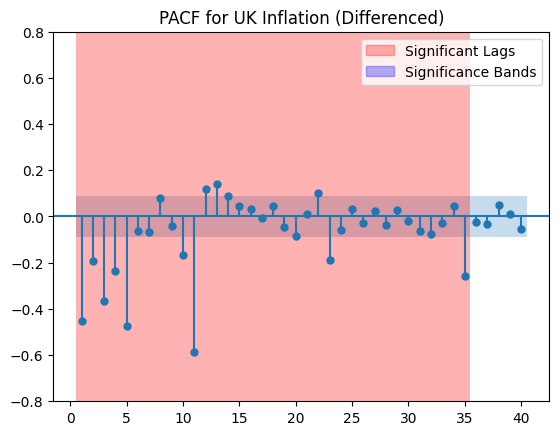

Lag with the lowest BIC: 11


,Lag,AIC,BIC,R2,Adj R2
0,1,-3753.63,-3745.35,0.2058,0.2040
1,2,-3763.22,-3750.80,0.2341,0.2308
2,3,-3820.10,-3803.55,0.3332,0.3289
3,4,-3836.22,-3815.54,0.3715,0.3660
4,5,-3946.04,-3921.24,0.5163,0.5110
5,6,-3936.20,-3907.28,0.5164,0.5100
6,7,-3927.58,-3894.54,0.5193,0.5119
7,8,-3920.67,-3883.53,0.5238,0.5153
8,9,-3914.64,-3873.39,0.5279,0.5184
9,10,-3916.52,-3871.17,0.5405,0.5301


In [66]:
df_uk_arp = df_uk.copy()
import matplotlib.patches as patches

fig, ax = plt.subplots()
sm.graphics.tsa.plot_pacf(df_uk_arp['infl_rate_diff'], lags=40, zero=False, title = "PACF for UK Inflation (Differenced)", ax=ax)

# Add a shaded rectangle for lags <= 35
rectangle = patches.Rectangle((0.5, -1), 35, 2, linewidth=0, edgecolor='none', facecolor='red', alpha=0.3)
ax.add_patch(rectangle)
red_patch = patches.Patch(color='red', alpha=0.3, label='Significant Lags')
blue_patch = patches.Patch(color='blue', alpha=0.3, label='Significance Bands')

# Add the legend to the plot
ax.legend(handles=[red_patch, blue_patch], loc='upper right')
plt.ylim(-0.8, 0.8)
plt.show()  # 35 lags

# Create a DataFrame to store AIC, BIC, and R² for AR(p) models
uk_ar_metrics = {}

# Loop through lag values from 1 to 40
for p in range(1, 41):
    # Create lagged variables up to lag p
    lagged_data = pd.concat([df_uk_arp['infl_rate_diff'].shift(i) for i in range(1, p + 1)], axis=1)
    lagged_data.columns = [f'infl_rate_diff_lag{i}' for i in range(1, p + 1)]
    
    # Combine lagged variables with the dependent variable
    data = pd.concat([df_uk_arp['infl_rate_diff'], lagged_data], axis=1).dropna()  # Drop rows with NaN values
    
    # Define dependent and independent variables
    y = data['infl_rate_diff']
    X = data.drop(columns=['infl_rate_diff'])
    X = sm.add_constant(X)  # Add constant to the independent variables
    
    # Fit the AR(p) model
    model = sm.OLS(y, X).fit()
    
    # Store AIC, BIC, and R² for the model
    uk_ar_metrics[p] = {
        'AIC': round(model.aic, 2),
        'BIC': round(model.bic, 2),
        'R2': round(model.rsquared, 4),
        'Adj R2': round(model.rsquared_adj, 4)
    }

# Convert the metrics dictionary to a DataFrame for easier analysis
uk_arp_metrics_df = pd.DataFrame.from_dict(uk_ar_metrics, orient='index')
uk_arp_metrics_df.index.name = 'Lag'
uk_arp_metrics_df.reset_index(inplace=True)

# Save best lag based on BIC
uk_arp_lag = uk_arp_metrics_df[uk_arp_metrics_df["BIC"] == uk_arp_metrics_df["BIC"].min()]["Lag"].values[0]
print(f'Lag with the lowest BIC: {uk_arp_lag}')

# Display the metrics
uk_arp_metrics_df

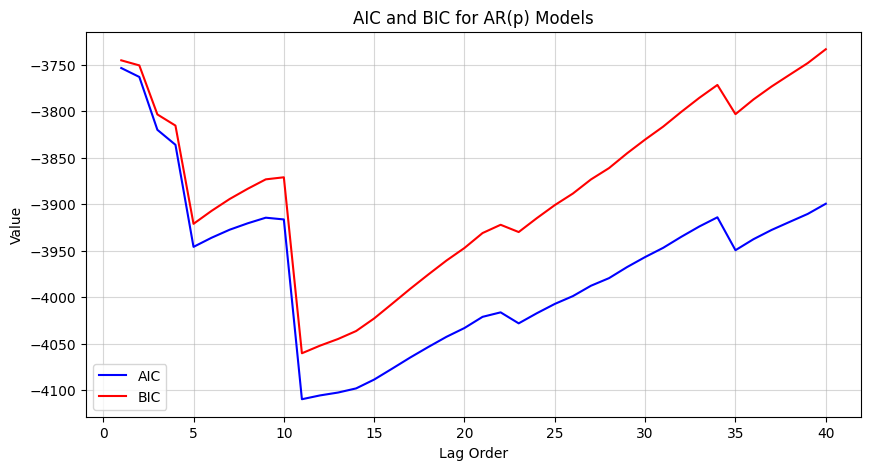

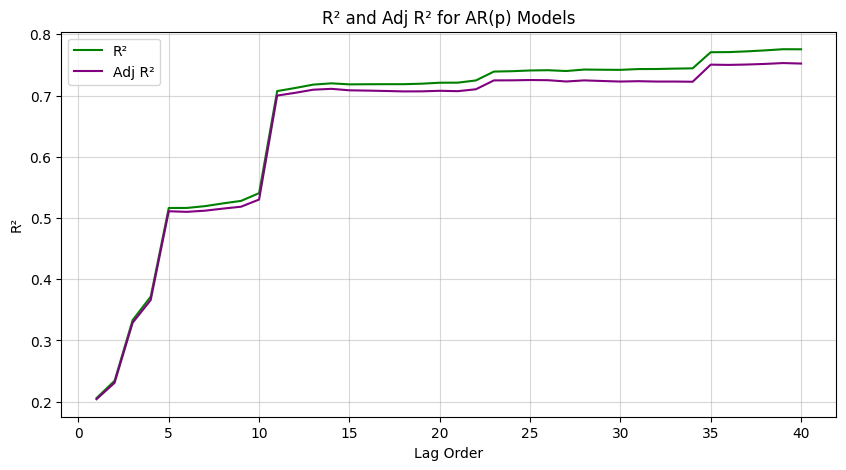

In [13]:
# Plot AIC and BIC values together
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(uk_arp_metrics_df['Lag'], uk_arp_metrics_df['AIC'], label='AIC', color='blue')
ax.plot(uk_arp_metrics_df['Lag'], uk_arp_metrics_df['BIC'], label='BIC', color='red')
ax.set_title('AIC and BIC for AR(p) Models')
ax.set_xlabel('Lag Order')
ax.set_ylabel('Value')
ax.legend()
ax.grid(alpha=0.5)
plt.show()

# Plot R² and Adjusted R² values together
plt.figure(figsize=(10, 5))
plt.plot(uk_arp_metrics_df['Lag'], uk_arp_metrics_df['R2'], label='R²', color='green')
plt.plot(uk_arp_metrics_df['Lag'], uk_arp_metrics_df['Adj R2'], label='Adj R²', color='purple')
plt.title('R² and Adj R² for AR(p) Models')
plt.xlabel('Lag Order')
plt.ylabel('R²')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

## US

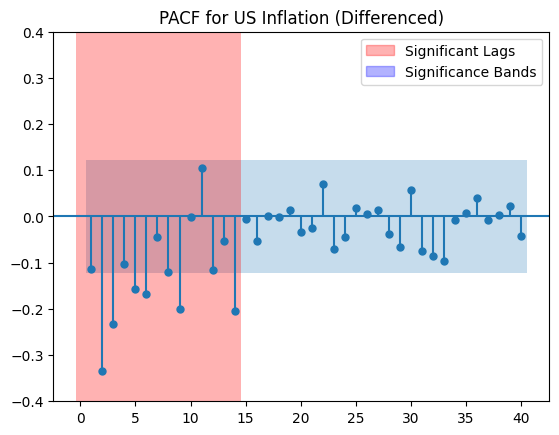

Lag with the lowest BIC: 3


,Lag,AIC,BIC,R2,Adj R2
0,1,-2256.51,-2249.39,0.0132,0.0094
1,2,-2276.54,-2265.86,0.1253,0.1185
2,3,-2280.17,-2265.96,0.1758,0.1660
3,4,-2271.34,-2253.59,0.1851,0.1721
4,5,-2267.33,-2246.06,0.2039,0.1880
5,6,-2262.95,-2238.16,0.2263,0.2075
6,7,-2251.83,-2223.53,0.2273,0.2053
7,8,-2244.39,-2212.59,0.2401,0.2152
8,9,-2243.60,-2208.31,0.2717,0.2446
9,10,-2231.77,-2192.99,0.2721,0.2418


In [50]:
df_us_arp = df_us.copy()
import matplotlib.patches as patches

fig, ax = plt.subplots()
sm.graphics.tsa.plot_pacf(df_us_arp['infl_rate_diff'], lags=40, zero=False, title = "PACF for US Inflation (Differenced)", ax=ax)

# Add a shaded rectangle for lags <= 14
rectangle = patches.Rectangle((-0.4, -0.4), 15, 0.8, linewidth=0, edgecolor='none', facecolor='red', alpha=0.3)
ax.add_patch(rectangle)
red_patch = patches.Patch(color='red', alpha=0.3, label='Significant Lags')
blue_patch = patches.Patch(color='blue', alpha=0.3, label='Significance Bands')

# Add the legend to the plot
ax.legend(handles=[red_patch, blue_patch], loc='upper right')
plt.ylim(-0.4, 0.4)
plt.show()  # 14 lags

# Create a DataFrame to store AIC, BIC, and R² for AR(p) models
us_ar_metrics = {}

# Loop through lag values from 1 to 40
for p in range(1, 41):
    # Create lagged variables up to lag p
    lagged_data = pd.concat([df_us_arp['infl_rate_diff'].shift(i) for i in range(1, p + 1)], axis=1)
    lagged_data.columns = [f'infl_rate_diff_lag{i}' for i in range(1, p + 1)]
    
    # Combine lagged variables with the dependent variable
    data = pd.concat([df_us_arp['infl_rate_diff'], lagged_data], axis=1).dropna()  # Drop rows with NaN values
    
    # Define dependent and independent variables
    y = data['infl_rate_diff']
    X = data.drop(columns=['infl_rate_diff'])
    X = sm.add_constant(X)  # Add constant to the independent variables
    
    # Fit the AR(p) model
    model = sm.OLS(y, X).fit()
    
    # Store AIC, BIC, and R² for the model
    us_ar_metrics[p] = {
        'AIC': round(model.aic, 2),
        'BIC': round(model.bic, 2),
        'R2': round(model.rsquared, 4),
        'Adj R2': round(model.rsquared_adj, 4)
    }

# Convert the metrics dictionary to a DataFrame for easier analysis
us_arp_metrics_df = pd.DataFrame.from_dict(us_ar_metrics, orient='index')
us_arp_metrics_df.index.name = 'Lag'
us_arp_metrics_df.reset_index(inplace=True)

# Save best lag based on BIC
us_arp_lag = us_arp_metrics_df[us_arp_metrics_df["BIC"] == us_arp_metrics_df["BIC"].min()]["Lag"].values[0]
print(f'Lag with the lowest BIC: {us_arp_lag}')

# Display the metrics
us_arp_metrics_df

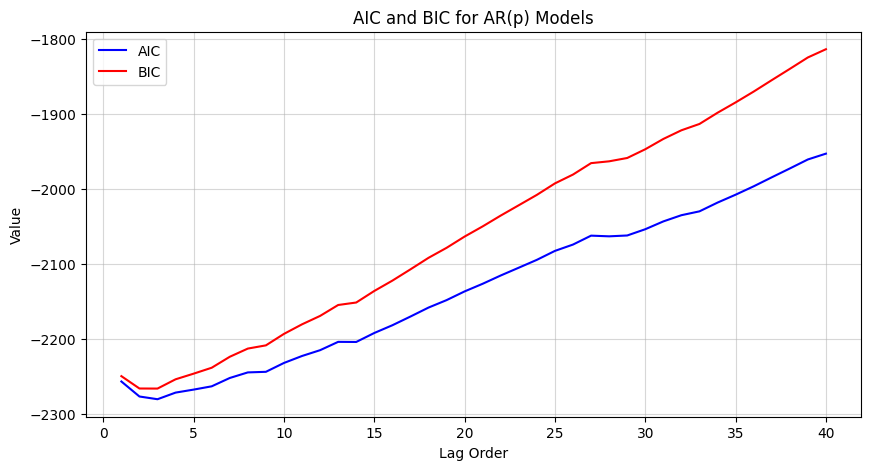

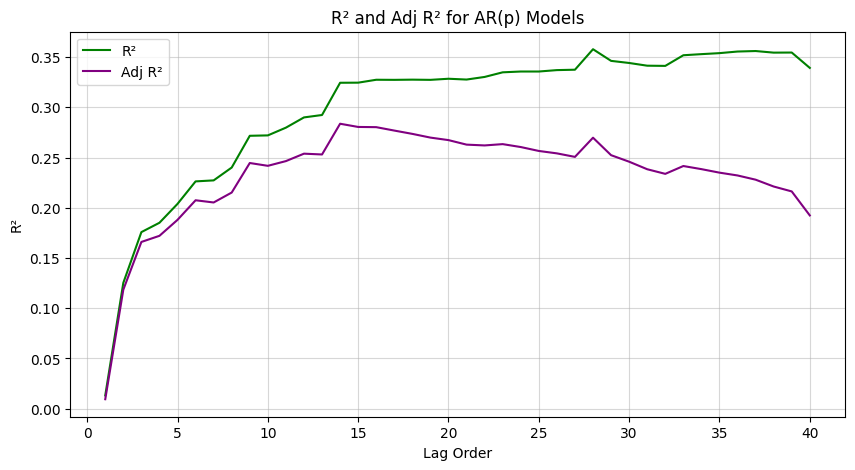

In [15]:
# Plot AIC and BIC values together
fig, ax = plt.subplots(figsize=(10, 5))
ax.plot(us_arp_metrics_df['Lag'], us_arp_metrics_df['AIC'], label='AIC', color='blue')
ax.plot(us_arp_metrics_df['Lag'], us_arp_metrics_df['BIC'], label='BIC', color='red')
ax.set_title('AIC and BIC for AR(p) Models')
ax.set_xlabel('Lag Order')
ax.set_ylabel('Value')
ax.legend()
ax.grid(alpha=0.5)
plt.show()

# Plot R² and Adjusted R² values together
plt.figure(figsize=(10, 5))
plt.plot(us_arp_metrics_df['Lag'], us_arp_metrics_df['R2'], label='R²', color='green')
plt.plot(us_arp_metrics_df['Lag'], us_arp_metrics_df['Adj R2'], label='Adj R²', color='purple')
plt.title('R² and Adj R² for AR(p) Models')
plt.xlabel('Lag Order')
plt.ylabel('R²')
plt.legend()
plt.grid(alpha=0.5)
plt.show()

## Did you obtain a higher R² with the additional lags?

**UK**
- Baseline: AR(1) R² = 0.206
- PACF: AR(39) R² = 0.7756
- AIC & BIC: AR(11) R² = 0.7072

**US**
- Baseline: AR(1) R² = 0.013
- PACF: AR(25) R² = 0.3579
- AIC & BIC: AR(3) R² = 0.1758

Using AIC & BIC to select AR(`p`) seems to achieve much higher R² than AR(1).

Using PACF achieves even higher R². However, R² as a metric can only increase as you add more lags.

Adjusted R² is plotted alongside to penalise the model for more lags being added.

# Autoregressive Distributed Lag (ADL) Model

## How should you determine the orders `p` and `q`?

1. **Information Criteria:**
    - Use Akaike Information Criterion (AIC) or Bayesian Information Criterion (BIC).
    - Fit ADL models with different combinations of `p` (lags of the dependent variable) and `q` (lags of the independent variable).
    - Select the model with the lowest AIC or BIC value.

2. **Partial Autocorrelation Function (PACF):**
    - Use the PACF plot of the dependent variable to determine the appropriate lag order `p`.
    - The lag at which the PACF cuts off (becomes insignificant) is a good candidate for `p`.
    - Already done as seen above.
    - Does not help determine order `q`.

3. **Residual Diagnostics:**
    - Check the residuals of the fitted model for autocorrelation and stationarity.
    - Adjust `p` and `q` to ensure that the residuals meet the assumptions of the model.

## UK

In [18]:
# Define the range of lags for p (infl_rate_diff lags) and q (independent variable lags)
# max_p = 5  # Maximum number of lags for infl_rate_diff
max_q = 20  # Maximum number of lags for independent variables

# List of independent variables to loop through
independent_vars = ['ppi_diff', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']

# Create a dictionary to store the results
results = []

# Loop through each independent variable
for var in independent_vars:
    # Loop through all combinations of p and q
    # for p in range(1, max_p + 1):  # Loop over lags for infl_rate_diff
    for p in [1, 35, 11]:  # Loop over p lags for infl_rate_diff as determined previously
        for q in range(0, max_q + 1):  # Loop over lags for the current independent variable
            # Create lagged variables for infl_rate_diff
            df_uk_adl = df_uk.copy()
            for lag in range(1, p + 1):
                df_uk_adl[f'infl_rate_diff_lag{lag}'] = df_uk_adl['infl_rate_diff'].shift(lag)
            
            # Create lagged variables for the current independent variable
            for lag in range(1, q + 1):
                df_uk_adl[f'{var}_lag{lag}'] = df_uk_adl[var].shift(lag)
            
            # Drop rows with NaN values due to lagging
            df_uk_adl = df_uk_adl.dropna()
            
            # Define dependent and independent variables
            y = df_uk_adl['infl_rate_diff']
            X = df_uk_adl.drop(columns=['infl_rate_diff', 'ppi_diff', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate', 'date'])  # Drop original columns and non-numeric columns
            X = sm.add_constant(X)  # Add a constant to the independent variables
            
            # Fit the ADL model
            model = sm.OLS(y, X).fit()
            
            # Store the results
            results.append({
                'Variable': var,
                'p': p,
                'q': q,
                'AIC': round(model.aic, 2),
                'BIC': round(model.bic, 2),
                'R2': round(model.rsquared, 4),
                'Adj R2': round(model.rsquared_adj, 4)
            })

# Convert the results to a DataFrame for easier analysis
uk_adl_metrics = pd.DataFrame(results)

# Get row with lowest AIC & BIC for each variable
# print('Lowest AIC for each variable:')
# print(uk_adl_metrics.loc[uk_adl_metrics.groupby('Variable')['AIC'].idxmin()])
print('\nLowest BIC for each variable:')
uk_adl_best_bic = uk_adl_metrics.loc[uk_adl_metrics.groupby('Variable')['BIC'].idxmin()]
print(uk_adl_best_bic)

# Display the results
uk_adl_metrics


Lowest BIC for each variable:
           Variable   p   q      AIC      BIC      R2  Adj R2
232       cons_conf  11   1 -4672.27 -4614.58  0.9157  0.9132
116  gdp_pct_change  11  11 -4719.95 -4621.07  0.9273  0.9234
169          int_3m  11   1 -4777.66 -4719.97  0.9331  0.9311
54         ppi_diff  11  12 -4816.94 -4713.99  0.9430  0.9398
298        unm_rate  11   4 -4689.74 -4619.70  0.9199  0.9170


,Variable,p,q,AIC,BIC,R2,Adj R2
0,ppi_diff,1,0,-4145.81,-4133.39,0.6597,0.6583
1,ppi_diff,1,1,-4219.14,-4202.57,0.7106,0.7087
2,ppi_diff,1,2,-4259.54,-4238.84,0.7395,0.7372
3,ppi_diff,1,3,-4251.40,-4226.57,0.7396,0.7367
4,ppi_diff,1,4,-4241.96,-4213.01,0.7411,0.7377
...,...,...,...,...,...,...,...
310,unm_rate,11,16,-4627.11,-4507.94,0.9214,0.9161
311,unm_rate,11,17,-4615.76,-4492.55,0.9217,0.9163
312,unm_rate,11,18,-4608.31,-4481.06,0.9226,0.9171
313,unm_rate,11,19,-4596.12,-4464.84,0.9229,0.9171


## US

In [ ]:
# Define the range of lags for p (infl_rate_diff lags) and q (independent variable lags)
# max_p = 5  # Maximum number of lags for infl_rate_diff
max_q = 20  # Maximum number of lags for independent variables

# List of independent variables to loop through
independent_vars = ['ppi_diff', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate']

# Create a dictionary to store the results
results = []

# Loop through each independent variable
for var in independent_vars:
    # Loop through all combinations of p and q
    # for p in range(1, max_p + 1):  # Loop over lags for infl_rate_diff
    for p in [1, 14, 3]:  # Loop over p lags for infl_rate_diff as determined previously
        for q in range(0, max_q + 1):  # Loop over lags for the current independent variable
            # Create lagged variables for infl_rate_diff
            df_us_adl = df_us.copy()
            for lag in range(1, p + 1):
                df_us_adl[f'infl_rate_diff_lag{lag}'] = df_us_adl['infl_rate_diff'].shift(lag)
            
            # Create lagged variables for the current independent variable
            for lag in range(1, q + 1):
                df_us_adl[f'{var}_lag{lag}'] = df_us_adl[var].shift(lag)
            
            # Drop rows with NaN values due to lagging
            df_us_adl = df_us_adl.dropna()
            
            # Define dependent and independent variables
            y = df_us_adl['infl_rate_diff']
            X = df_us_adl.drop(columns=['infl_rate_diff', 'ppi_diff', 'gdp_pct_change', 'int_3m', 'cons_conf', 'unm_rate', 'date'])  # Drop original columns and non-numeric columns
            X = sm.add_constant(X)  # Add a constant to the independent variables
            
            # Fit the ADL model
            model = sm.OLS(y, X).fit()
            
            # Store the results
            results.append({
                'Variable': var,
                'p': p,
                'q': q,
                'AIC': round(model.aic, 2),
                'BIC': round(model.bic, 2),
                'R2': round(model.rsquared, 4),
                'Adj R2': round(model.rsquared_adj, 4)
            })

# Convert the results to a DataFrame for easier analysis
us_adl_metrics = pd.DataFrame(results)

# Get row with lowest AIC & BIC for each variable
# print('Lowest AIC for each variable:')
# print(us_adl_metrics.loc[us_adl_metrics.groupby('Variable')['AIC'].idxmin()])
print('\nLowest BIC for each variable:')
us_adl_best_bic = us_adl_metrics.loc[us_adl_metrics.groupby('Variable')['BIC'].idxmin()]
print(us_adl_best_bic)

# Display the results
us_adl_metrics


Lowest BIC for each variable:
           Variable   p   q      AIC      BIC      R2  Adj R2
211       cons_conf  14   1 -2590.98 -2531.32  0.8614  0.8518
98   gdp_pct_change  14  14 -2717.22 -2611.93  0.9252  0.9152
150          int_3m  14   3 -2634.09 -2567.41  0.8855  0.8764
35         ppi_diff  14  14 -2757.24 -2651.96  0.9364  0.9279
274        unm_rate  14   1 -2590.40 -2530.74  0.8611  0.8514


,Variable,p,q,AIC,BIC,R2,Adj R2
0,ppi_diff,1,0,-2366.74,-2356.06,0.3591,0.3541
1,ppi_diff,1,1,-2500.01,-2485.77,0.6191,0.6146
2,ppi_diff,1,2,-2568.29,-2550.51,0.7208,0.7164
3,ppi_diff,1,3,-2556.92,-2535.60,0.7224,0.7169
4,ppi_diff,1,4,-2546.39,-2521.54,0.7249,0.7182
...,...,...,...,...,...,...,...
310,unm_rate,2,16,-2297.03,-2227.00,0.5905,0.5559
311,unm_rate,2,17,-2285.05,-2211.61,0.5907,0.5540
312,unm_rate,2,18,-2272.53,-2195.69,0.5907,0.5518
313,unm_rate,2,19,-2262.73,-2182.48,0.5917,0.5507


## Did you obtain a higher R² with the additional lags?

Yes R² is always higher with additional lags for `p`.

Additional lags of `q` also achieves higher R², though often 1 lag of `q` is sufficient.

# Pseudo Out-of-Sample Forecast

## UK

### AR(1)

In [13]:
# Create lagged variables for the regression
df_uk_ar1_rolling = df_uk.copy()
df_uk_ar1_rolling['infl_rate_diff_lag1'] = df_uk_ar1_rolling['infl_rate_diff'].shift(1)  # Lagged dependent variable

# Drop rows with NaN values due to lagging
df_uk_ar1_rolling = df_uk_ar1_rolling.dropna()

# Initialize variables for rolling window forecasting
results = []  # To store results as a list of dictionaries
rolling_window_size = 120  # Set the rolling window size to 120

# Ensure there are enough observations for the rolling window
if len(df_uk_ar1_rolling) < rolling_window_size:
    raise ValueError("Not enough data for the specified rolling window size.")

# Start with the first rolling window
for i in range(rolling_window_size, len(df_uk_ar1_rolling)):
    # Define the rolling window
    X_rolling = df_uk_ar1_rolling.iloc[i - rolling_window_size:i][['infl_rate_diff_lag1']]  # Independent variables
    y_rolling = df_uk_ar1_rolling.iloc[i - rolling_window_size:i]['infl_rate_diff']  # Dependent variable
    
    # Add a constant to the independent variables
    X_rolling = sm.add_constant(X_rolling)
    
    # Fit the model on the rolling window
    rolling_model = sm.OLS(y_rolling, X_rolling).fit()
    
    # Use the current observation for prediction
    current_row = df_uk_ar1_rolling.iloc[i][['infl_rate_diff_lag1']]
    current_row = pd.DataFrame([current_row])  # Convert to DataFrame to match shape
    current_row = sm.add_constant(current_row, has_constant='add')  # Add a constant to match the model
    
    # Predict infl_rate_diff
    forecast_diff = rolling_model.predict(current_row)  # Predict infl_rate_diff
    
    # Compute infl_rate_T = infl_rate_diff_T + infl_rate_T-1
    last_infl_rate = df_uk_ar1_rolling.iloc[i - 1]['infl_rate']  # infl_rate at T-1
    forecast_infl_rate = forecast_diff.iloc[0] + last_infl_rate
    
    # Calculate the standard error of the forecast
    se = np.sqrt(rolling_model.mse_resid)  # Standard error of residuals
    z = st.norm.ppf(0.975)  # Critical value for 95% confidence interval
    lower_bound = forecast_infl_rate - z * se
    upper_bound = forecast_infl_rate + z * se
    
    # Store the results in a dictionary
    results.append({
        'Date': df_uk_ar1_rolling.iloc[i]['date'],
        'Forecast_infl_rate': forecast_infl_rate,
        'Actual_infl_rate': df_uk_ar1_rolling.iloc[i]['infl_rate'],
        'Lower_95_FI': lower_bound,
        'Upper_95_FI': upper_bound
    })

# Convert results to a pandas DataFrame
uk_ar1_forecast_results = pd.DataFrame(results)

# Calculate RMSE for infl_rate
rmse_infl_rate = np.sqrt(mean_squared_error(uk_ar1_forecast_results['Actual_infl_rate'], uk_ar1_forecast_results['Forecast_infl_rate']))
print(f"Root Mean Squared Error (RMSE) for infl_rate: {rmse_infl_rate:.4f}")

# Within 95% forecast interval
uk_ar1_forecast_results['Within_95_FI'] = (uk_ar1_forecast_results['Actual_infl_rate'] >= uk_ar1_forecast_results['Lower_95_FI']) & (uk_ar1_forecast_results['Actual_infl_rate'] <= uk_ar1_forecast_results['Upper_95_FI'])

# Display uk_ar1_forecast_results
uk_ar1_forecast_results

Root Mean Squared Error (RMSE) for infl_rate: 0.0039


,Date,Forecast_infl_rate,Actual_infl_rate,Lower_95_FI,Upper_95_FI,Within_95_FI
0,1996-04-01,0.003539,0.005891,-0.006612,0.013689,True
1,1996-05-01,0.004764,0.004392,-0.005289,0.014817,True
2,1996-06-01,0.004944,0.001458,-0.005052,0.014941,True
3,1996-07-01,0.002562,-0.005822,-0.007423,0.012547,True
4,1996-08-01,-0.003201,0.005857,-0.013280,0.006878,True
...,...,...,...,...,...,...
340,2024-08-01,0.000826,0.003762,-0.007296,0.008949,True
341,2024-09-01,0.001431,0.000750,-0.006692,0.009553,True
342,2024-10-01,0.002321,0.005993,-0.005802,0.010444,True
343,2024-11-01,0.003276,0.002234,-0.004871,0.011423,True


### AR(`p`)

In [14]:
# Create lagged variables for AR(p) model
df_uk_arp_rolling = df_uk.copy()

# Add lagged variables for infl_rate_diff up to the pth lag
for lag in range(1, uk_arp_lag+1):  # Create lags from 1 to p
    df_uk_arp_rolling[f'infl_rate_diff_lag{lag}'] = df_uk_arp_rolling['infl_rate_diff'].shift(lag)

# Drop rows with NaN values due to lagging
df_uk_arp_rolling = df_uk_arp_rolling.dropna()

# Define dependent and independent variables
y = df_uk_arp_rolling['infl_rate_diff']  # Dependent variable
X = df_uk_arp_rolling[[f'infl_rate_diff_lag{lag}' for lag in range(1, uk_arp_lag+1)]]  # Include all lagged variables
X = sm.add_constant(X)  # Add a constant to the independent variables

# Initialize variables for rolling window forecasting
rolling_window_size = 120  # Set the rolling window size to 120
forecasts_diff = []  # To store the forecasts for infl_rate_diff
forecasts_infl_rate = []  # To store the forecasts for infl_rate
forecast_intervals = []  # To store the forecast intervals for infl_rate
actuals_infl_rate = df_uk_arp_rolling['infl_rate'].iloc[rolling_window_size:].tolist()  # Actual values for infl_rate

# Ensure there are enough observations for the rolling window
if len(df_uk_arp_rolling) < rolling_window_size:
    raise ValueError("Not enough data for the specified rolling window size.")

# Start with the first rolling window
for i in range(rolling_window_size, len(df_uk_arp_rolling)):
    # Define the rolling window
    X_rolling = X.iloc[i - rolling_window_size:i]  # Independent variables for the rolling window
    y_rolling = y.iloc[i - rolling_window_size:i]  # Dependent variable for the rolling window
    
    # Fit the AR(p) model on the rolling window
    rolling_model = sm.OLS(y_rolling, X_rolling).fit()
    
    # Use the current observation for prediction
    current_row = X.iloc[i]
    forecast_diff = rolling_model.predict(current_row)  # Predict infl_rate_diff
    
    # Compute infl_rate_T = infl_rate_diff_T + infl_rate_T-1
    last_infl_rate = df_uk_arp_rolling.iloc[i - 1]['infl_rate']  # infl_rate at T-1
    forecast_infl_rate = forecast_diff.iloc[0] + last_infl_rate
    forecasts_infl_rate.append(forecast_infl_rate)  # Store the forecasted infl_rate
    
    # Calculate the standard error of the forecast
    se = np.sqrt(rolling_model.mse_resid)  # Standard error of residuals
    z = 1.96  # Critical value for 95% confidence interval
    lower_bound = forecast_infl_rate - z * se
    upper_bound = forecast_infl_rate + z * se
    forecast_intervals.append((lower_bound, upper_bound))  # Store the forecast interval

# Calculate RMSE for infl_rate
rmse_infl_rate = np.sqrt(mean_squared_error(actuals_infl_rate, forecasts_infl_rate))
print(f"Root Mean Squared Error (RMSE) for infl_rate: {rmse_infl_rate:.4f}")

# Store results in a pandas DataFrame
uk_arp_forecast_results = pd.DataFrame({
    'Date': df_uk_arp_rolling['date'].iloc[rolling_window_size:].values,  # Extract the 'date' column starting from the rolling window size
    'Forecast_infl_rate': forecasts_infl_rate,
    'Actual_infl_rate': actuals_infl_rate,
    'Lower_95_FI': [interval[0] for interval in forecast_intervals],
    'Upper_95_FI': [interval[1] for interval in forecast_intervals]
})

# Within 95% forecast interval
uk_arp_forecast_results['Within_95_FI'] = (uk_arp_forecast_results['Actual_infl_rate'] >= uk_arp_forecast_results['Lower_95_FI']) & (uk_arp_forecast_results['Actual_infl_rate'] <= uk_arp_forecast_results['Upper_95_FI'])

# Display the first few rows of the results DataFrame
uk_arp_forecast_results

Root Mean Squared Error (RMSE) for infl_rate: 0.0026


,Date,Forecast_infl_rate,Actual_infl_rate,Lower_95_FI,Upper_95_FI,Within_95_FI
0,1997-02-01,0.003110,0.001445,-0.002396,0.008615,True
1,1997-03-01,0.003095,0.001443,-0.002412,0.008603,True
2,1997-04-01,0.005361,0.004323,-0.000140,0.010862,True
3,1997-05-01,0.003051,0.004304,-0.002397,0.008500,True
4,1997-06-01,0.000832,0.001429,-0.004604,0.006268,True
...,...,...,...,...,...,...
330,2024-08-01,0.005291,0.003762,-0.000588,0.011170,True
331,2024-09-01,0.004196,0.000750,-0.001689,0.010081,True
332,2024-10-01,0.003139,0.005993,-0.002778,0.009056,True
333,2024-11-01,0.000067,0.002234,-0.005857,0.005991,True


### ADL(`p`, `q`)

In [15]:
# Initialize a list to store results for all macroeconomic variables
all_results = []

# Loop through each macroeconomic variable in uk_adl_best_bic
for _, row in uk_adl_best_bic.iterrows():
    var = row['Variable']  # Macro variable name
    p = int(row['p'])      # Number of lags for infl_rate_diff
    q = int(row['q'])      # Number of lags for the macroeconomic variable

    # Create a copy of the dataset
    df_rolling = df_uk.copy()

    # Add lagged variables for infl_rate_diff up to p lags
    for lag in range(1, p + 1):
        df_rolling[f'infl_rate_diff_lag{lag}'] = df_rolling['infl_rate_diff'].shift(lag)

    # Add lagged variables for the macroeconomic variable up to q lags
    for lag in range(1, q + 1):
        df_rolling[f'{var}_lag{lag}'] = df_rolling[var].shift(lag)

    # Drop rows with NaN values due to lagging
    df_rolling = df_rolling.dropna()

    # Define dependent and independent variables
    y = df_rolling['infl_rate_diff']  # Dependent variable
    X = df_rolling[[f'infl_rate_diff_lag{lag}' for lag in range(1, p + 1)] +
                   [f'{var}_lag{lag}' for lag in range(1, q + 1)]]  # Independent variables
    X = sm.add_constant(X)  # Add a constant to the independent variables

    # Initialize variables for rolling window forecasting
    rolling_window_size = 120  # Set the rolling window size to 120
    forecasts_diff = []  # To store the forecasts for infl_rate_diff
    forecasts_infl_rate = []  # To store the forecasts for infl_rate
    forecast_intervals = []  # To store the forecast intervals for infl_rate
    actuals_infl_rate = df_rolling['infl_rate'].iloc[rolling_window_size:].tolist()  # Actual values for infl_rate

    # Ensure there are enough observations for the rolling window
    if len(df_rolling) < rolling_window_size:
        raise ValueError("Not enough data for the specified rolling window size.")

    # Start with the first rolling window
    for i in range(rolling_window_size, len(df_rolling)):
        # Define the rolling window
        X_rolling = X.iloc[i - rolling_window_size:i]  # Independent variables for the rolling window
        y_rolling = y.iloc[i - rolling_window_size:i]  # Dependent variable for the rolling window

        # Fit the model on the rolling window
        rolling_model = sm.OLS(y_rolling, X_rolling).fit()

        # Use the current observation for prediction
        current_row = X.iloc[i]
        forecast_diff = rolling_model.predict(current_row)  # Predict infl_rate_diff

        # Compute infl_rate_T = infl_rate_diff_T + infl_rate_T-1
        last_infl_rate = df_rolling.iloc[i - 1]['infl_rate']  # infl_rate at T-1
        forecast_infl_rate = forecast_diff.iloc[0] + last_infl_rate
        forecasts_infl_rate.append(forecast_infl_rate)  # Store the forecasted infl_rate

        # Calculate the standard error of the forecast
        se = np.sqrt(rolling_model.mse_resid)  # Standard error of residuals
        z = 1.96  # Critical value for 95% confidence interval
        lower_bound = forecast_infl_rate - z * se
        upper_bound = forecast_infl_rate + z * se
        forecast_intervals.append((lower_bound, upper_bound))  # Store the forecast interval

    # Calculate RMSE for infl_rate
    rmse_infl_rate = np.sqrt(mean_squared_error(actuals_infl_rate, forecasts_infl_rate))
    print(f"Result for {var}: ADL({p}, {q})")
    print(f"Root Mean Squared Error (RMSE) for infl_rate: {rmse_infl_rate:.4f}")

    # Store results for the current variable in a DataFrame
    results_df = pd.DataFrame({
        'Date': df_rolling['date'].iloc[rolling_window_size:].values,  # Extract the 'date' column
        'Macro_Variable': var,  # Add the macroeconomic variable name
        'Forecast_infl_rate': forecasts_infl_rate,
        'Actual_infl_rate': actuals_infl_rate,
        'Lower_95_CI': [interval[0] for interval in forecast_intervals],
        'Upper_95_CI': [interval[1] for interval in forecast_intervals]
    })

    # Append the results to the list
    all_results.append(results_df)

# Concatenate all results into a single DataFrame
uk_adl_forecast_results = pd.concat(all_results, ignore_index=True)

# Within 95% forecast interval
uk_adl_forecast_results['Within_95_CI'] = (uk_adl_forecast_results['Actual_infl_rate'] >= uk_adl_forecast_results['Lower_95_CI']) & (uk_adl_forecast_results['Actual_infl_rate'] <= uk_adl_forecast_results['Upper_95_CI'])

# Display the first few rows of the final results DataFrame
uk_adl_forecast_results

Result for cons_conf: ADL(11, 1)
Root Mean Squared Error (RMSE) for infl_rate: 0.0026
Result for gdp_pct_change: ADL(11, 11)
Root Mean Squared Error (RMSE) for infl_rate: 0.0039
Result for int_3m: ADL(11, 1)
Root Mean Squared Error (RMSE) for infl_rate: 0.0026
Result for ppi: ADL(11, 16)
Root Mean Squared Error (RMSE) for infl_rate: 0.0026
Result for unm_rate: ADL(11, 4)
Root Mean Squared Error (RMSE) for infl_rate: 0.0027


,Date,Macro_Variable,Forecast_infl_rate,Actual_infl_rate,Lower_95_CI,Upper_95_CI,Within_95_CI
0,1997-02-01,cons_conf,0.003110,0.001445,-0.002421,0.008641,True
1,1997-03-01,cons_conf,0.003094,0.001443,-0.002439,0.008627,True
2,1997-04-01,cons_conf,0.005362,0.004323,-0.000165,0.010888,True
3,1997-05-01,cons_conf,0.003030,0.004304,-0.002441,0.008502,True
4,1997-06-01,cons_conf,0.000824,0.001429,-0.004637,0.006285,True
...,...,...,...,...,...,...,...
1665,2024-08-01,unm_rate,0.006326,0.003762,0.000551,0.012101,True
1666,2024-09-01,unm_rate,0.004750,0.000750,-0.001039,0.010539,True
1667,2024-10-01,unm_rate,0.002701,0.005993,-0.003120,0.008521,True
1668,2024-11-01,unm_rate,-0.001633,0.002234,-0.007459,0.004193,True


## US

### AR(1)

In [16]:
# Create lagged variables for the regression
df_us_ar1_rolling = df_us.copy()
df_us_ar1_rolling['infl_rate_diff_lag1'] = df_us_ar1_rolling['infl_rate_diff'].shift(1)  # Lagged dependent variable

# Drop rows with NaN values due to lagging
df_us_ar1_rolling = df_us_ar1_rolling.dropna()

# Initialize variables for rolling window forecasting
results = []  # To store results as a list of dictionaries
rolling_window_size = 120  # Set the rolling window size to 120

# Ensure there are enough observations for the rolling window
if len(df_us_ar1_rolling) < rolling_window_size:
    raise ValueError("Not enough data for the specified rolling window size.")

# Start with the first rolling window
for i in range(rolling_window_size, len(df_us_ar1_rolling)):
    # Define the rolling window
    X_rolling = df_us_ar1_rolling.iloc[i - rolling_window_size:i][['infl_rate_diff_lag1']]  # Independent variables
    y_rolling = df_us_ar1_rolling.iloc[i - rolling_window_size:i]['infl_rate_diff']  # Dependent variable
    
    # Add a constant to the independent variables
    X_rolling = sm.add_constant(X_rolling)
    
    # Fit the model on the rolling window
    rolling_model = sm.OLS(y_rolling, X_rolling).fit()
    
    # Use the current observation for prediction
    current_row = df_us_ar1_rolling.iloc[i][['infl_rate_diff_lag1']]
    current_row = pd.DataFrame([current_row])  # Convert to DataFrame to match shape
    current_row = sm.add_constant(current_row, has_constant='add')  # Add a constant to match the model
    
    # Predict infl_rate_diff
    forecast_diff = rolling_model.predict(current_row)  # Predict infl_rate_diff
    
    # Compute infl_rate_T = infl_rate_diff_T + infl_rate_T-1
    last_infl_rate = df_us_ar1_rolling.iloc[i - 1]['infl_rate']  # infl_rate at T-1
    forecast_infl_rate = forecast_diff.iloc[0] + last_infl_rate
    
    # Calculate the standard error of the forecast
    se = np.sqrt(rolling_model.mse_resid)  # Standard error of residuals
    z = st.norm.ppf(0.975)  # Critical value for 95% confidence interval
    lower_bound = forecast_infl_rate - z * se
    upper_bound = forecast_infl_rate + z * se
    
    # Store the results in a dictionary
    results.append({
        'Date': df_us_ar1_rolling.iloc[i]['date'],
        'Forecast_infl_rate': forecast_infl_rate,
        'Actual_infl_rate': df_us_ar1_rolling.iloc[i]['infl_rate'],
        'Lower_95_CI': lower_bound,
        'Upper_95_CI': upper_bound
    })

# Convert results to a pandas DataFrame
us_ar1_forecast_results = pd.DataFrame(results)

# Calculate RMSE for infl_rate
rmse_infl_rate = np.sqrt(mean_squared_error(us_ar1_forecast_results['Actual_infl_rate'], us_ar1_forecast_results['Forecast_infl_rate']))
print(f"Root Mean Squared Error (RMSE) for infl_rate: {rmse_infl_rate:.4f}")

# Within 95% forecast interval
us_ar1_forecast_results['Within_95_CI'] = (us_ar1_forecast_results['Actual_infl_rate'] >= us_ar1_forecast_results['Lower_95_CI']) & (us_ar1_forecast_results['Actual_infl_rate'] <= us_ar1_forecast_results['Upper_95_CI'])

# Display us_ar1_forecast_results
us_ar1_forecast_results

Root Mean Squared Error (RMSE) for infl_rate: 0.0026


,Date,Forecast_infl_rate,Actual_infl_rate,Lower_95_CI,Upper_95_CI,Within_95_CI
0,2013-07-01,0.002236,0.001957,-0.005106,0.009578,True
1,2013-08-01,0.001983,0.002387,-0.005346,0.009312,True
2,2013-09-01,0.002333,0.000377,-0.004993,0.009659,True
3,2013-10-01,0.000523,0.000535,-0.006809,0.007856,True
4,2013-11-01,0.000533,0.001844,-0.006756,0.007821,True
...,...,...,...,...,...,...
135,2024-10-01,0.002226,0.002265,-0.003095,0.007546,True
136,2024-11-01,0.002293,0.002805,-0.003027,0.007614,True
137,2024-12-01,0.002750,0.003647,-0.002561,0.008062,True
138,2025-01-01,0.003557,0.004669,-0.001750,0.008863,True


### AR(`p`)

In [17]:
# Create lagged variables for AR(p) model
df_us_arp_rolling = df_us.copy()

# Add lagged variables for infl_rate_diff up to the pth lag
for lag in range(1, us_arp_lag+1):  # Create lags from 1 to p
    df_us_arp_rolling[f'infl_rate_diff_lag{lag}'] = df_us_arp_rolling['infl_rate_diff'].shift(lag)

# Drop rows with NaN values due to lagging
df_us_arp_rolling = df_us_arp_rolling.dropna()

# Define dependent and independent variables
y = df_us_arp_rolling['infl_rate_diff']  # Dependent variable
X = df_us_arp_rolling[[f'infl_rate_diff_lag{lag}' for lag in range(1, us_arp_lag+1)]]  # Include all lagged variables
X = sm.add_constant(X)  # Add a constant to the independent variables

# Initialize variables for rolling window forecasting
rolling_window_size = 120  # Set the rolling window size to 120
forecasts_diff = []  # To store the forecasts for infl_rate_diff
forecasts_infl_rate = []  # To store the forecasts for infl_rate
forecast_intervals = []  # To store the forecast intervals for infl_rate
actuals_infl_rate = df_us_arp_rolling['infl_rate'].iloc[rolling_window_size:].tolist()  # Actual values for infl_rate

# Ensure there are enough observations for the rolling window
if len(df_us_arp_rolling) < rolling_window_size:
    raise ValueError("Not enough data for the specified rolling window size.")

# Start with the first rolling window
for i in range(rolling_window_size, len(df_us_arp_rolling)):
    # Define the rolling window
    X_rolling = X.iloc[i - rolling_window_size:i]  # Independent variables for the rolling window
    y_rolling = y.iloc[i - rolling_window_size:i]  # Dependent variable for the rolling window
    
    # Fit the AR(p) model on the rolling window
    rolling_model = sm.OLS(y_rolling, X_rolling).fit()
    
    # Use the current observation for prediction
    current_row = X.iloc[i]
    forecast_diff = rolling_model.predict(current_row)  # Predict infl_rate_diff
    
    # Compute infl_rate_T = infl_rate_diff_T + infl_rate_T-1
    last_infl_rate = df_us_arp_rolling.iloc[i - 1]['infl_rate']  # infl_rate at T-1
    forecast_infl_rate = forecast_diff.iloc[0] + last_infl_rate
    forecasts_infl_rate.append(forecast_infl_rate)  # Store the forecasted infl_rate
    
    # Calculate the standard error of the forecast
    se = np.sqrt(rolling_model.mse_resid)  # Standard error of residuals
    z = 1.96  # Critical value for 95% confidence interval
    lower_bound = forecast_infl_rate - z * se
    upper_bound = forecast_infl_rate + z * se
    forecast_intervals.append((lower_bound, upper_bound))  # Store the forecast interval

# Calculate RMSE for infl_rate
rmse_infl_rate = np.sqrt(mean_squared_error(actuals_infl_rate, forecasts_infl_rate))
print(f"Root Mean Squared Error (RMSE) for infl_rate: {rmse_infl_rate:.4f}")

# Store results in a pandas DataFrame
us_arp_forecast_results = pd.DataFrame({
    'Date': df_us_arp_rolling['date'].iloc[rolling_window_size:].values,  # Extract the 'date' column starting from the rolling window size
    'Forecast_infl_rate': forecasts_infl_rate,
    'Actual_infl_rate': actuals_infl_rate,
    'Lower_95_CI': [interval[0] for interval in forecast_intervals],
    'Upper_95_CI': [interval[1] for interval in forecast_intervals]
})

# Within 95% forecast interval
us_arp_forecast_results['Within_95_CI'] = (us_arp_forecast_results['Actual_infl_rate'] >= us_arp_forecast_results['Lower_95_CI']) & (us_arp_forecast_results['Actual_infl_rate'] <= us_arp_forecast_results['Upper_95_CI'])

# Display the first few rows of the results DataFrame
us_arp_forecast_results

Root Mean Squared Error (RMSE) for infl_rate: 0.0024


,Date,Forecast_infl_rate,Actual_infl_rate,Lower_95_CI,Upper_95_CI,Within_95_CI
0,2013-09-01,0.001882,0.000377,-0.004819,0.008583,True
1,2013-10-01,0.000733,0.000535,-0.005973,0.007438,True
2,2013-11-01,0.001089,0.001844,-0.005586,0.007763,True
3,2013-12-01,0.002088,0.002644,-0.004587,0.008763,True
4,2014-01-01,0.001976,0.002424,-0.004698,0.008651,True
...,...,...,...,...,...,...
133,2024-10-01,0.001787,0.002265,-0.003131,0.006704,True
134,2024-11-01,0.002043,0.002805,-0.002874,0.006959,True
135,2024-12-01,0.002634,0.003647,-0.002272,0.007540,True
136,2025-01-01,0.003249,0.004669,-0.001649,0.008146,True


### ADL(`p`, `q`)

In [18]:
# Initialize a list to store results for all macroeconomic variables
all_results = []

# Loop through each macroeconomic variable in us_adl_best_bic
for _, row in us_adl_best_bic.iterrows():
    var = row['Variable']  # Macro variable name
    p = int(row['p'])      # Number of lags for infl_rate_diff
    q = int(row['q'])      # Number of lags for the macroeconomic variable

    # Create a copy of the dataset
    df_rolling = df_us.copy()

    # Add lagged variables for infl_rate_diff up to p lags
    for lag in range(1, p + 1):
        df_rolling[f'infl_rate_diff_lag{lag}'] = df_rolling['infl_rate_diff'].shift(lag)

    # Add lagged variables for the macroeconomic variable up to q lags
    for lag in range(1, q + 1):
        df_rolling[f'{var}_lag{lag}'] = df_rolling[var].shift(lag)

    # Drop rows with NaN values due to lagging
    df_rolling = df_rolling.dropna()

    # Define dependent and independent variables
    y = df_rolling['infl_rate_diff']  # Dependent variable
    X = df_rolling[[f'infl_rate_diff_lag{lag}' for lag in range(1, p + 1)] +
                   [f'{var}_lag{lag}' for lag in range(1, q + 1)]]  # Independent variables
    X = sm.add_constant(X)  # Add a constant to the independent variables

    # Initialize variables for rolling window forecasting
    rolling_window_size = 120  # Set the rolling window size to 120
    forecasts_diff = []  # To store the forecasts for infl_rate_diff
    forecasts_infl_rate = []  # To store the forecasts for infl_rate
    forecast_intervals = []  # To store the forecast intervals for infl_rate
    actuals_infl_rate = df_rolling['infl_rate'].iloc[rolling_window_size:].tolist()  # Actual values for infl_rate

    # Ensure there are enough observations for the rolling window
    if len(df_rolling) < rolling_window_size:
        raise ValueError("Not enough data for the specified rolling window size.")

    # Start with the first rolling window
    for i in range(rolling_window_size, len(df_rolling)):
        # Define the rolling window
        X_rolling = X.iloc[i - rolling_window_size:i]  # Independent variables for the rolling window
        y_rolling = y.iloc[i - rolling_window_size:i]  # Dependent variable for the rolling window

        # Fit the model on the rolling window
        rolling_model = sm.OLS(y_rolling, X_rolling).fit()

        # Use the current observation for prediction
        current_row = X.iloc[i]
        forecast_diff = rolling_model.predict(current_row)  # Predict infl_rate_diff

        # Compute infl_rate_T = infl_rate_diff_T + infl_rate_T-1
        last_infl_rate = df_rolling.iloc[i - 1]['infl_rate']  # infl_rate at T-1
        forecast_infl_rate = forecast_diff.iloc[0] + last_infl_rate
        forecasts_infl_rate.append(forecast_infl_rate)  # Store the forecasted infl_rate

        # Calculate the standard error of the forecast
        se = np.sqrt(rolling_model.mse_resid)  # Standard error of residuals
        z = 1.96  # Critical value for 95% confidence interval
        lower_bound = forecast_infl_rate - z * se
        upper_bound = forecast_infl_rate + z * se
        forecast_intervals.append((lower_bound, upper_bound))  # Store the forecast interval

    # Calculate RMSE for infl_rate
    rmse_infl_rate = np.sqrt(mean_squared_error(actuals_infl_rate, forecasts_infl_rate))
    print(f"Result for {var}: ADL({p}, {q})")
    print(f"Root Mean Squared Error (RMSE) for infl_rate: {rmse_infl_rate:.4f}")

    # Store results for the current variable in a DataFrame
    results_df = pd.DataFrame({
        'Date': df_rolling['date'].iloc[rolling_window_size:].values,  # Extract the 'date' column
        'Macro_Variable': var,  # Add the macroeconomic variable name
        'Forecast_infl_rate': forecasts_infl_rate,
        'Actual_infl_rate': actuals_infl_rate,
        'Lower_95_CI': [interval[0] for interval in forecast_intervals],
        'Upper_95_CI': [interval[1] for interval in forecast_intervals]
    })

    # Append the results to the list
    all_results.append(results_df)

# Concatenate all results into a single DataFrame
us_adl_forecast_results = pd.concat(all_results, ignore_index=True)

# Within 95% forecast interval
us_adl_forecast_results['Within_95_CI'] = (us_adl_forecast_results['Actual_infl_rate'] >= us_adl_forecast_results['Lower_95_CI']) & (us_adl_forecast_results['Actual_infl_rate'] <= us_adl_forecast_results['Upper_95_CI'])

# Display the first few rows of the final results DataFrame
us_adl_forecast_results

Result for cons_conf: ADL(14, 1)
Root Mean Squared Error (RMSE) for infl_rate: 0.0025
Result for gdp_pct_change: ADL(14, 14)
Root Mean Squared Error (RMSE) for infl_rate: 0.0042
Result for int_3m: ADL(14, 3)
Root Mean Squared Error (RMSE) for infl_rate: 0.0025
Result for ppi: ADL(14, 14)
Root Mean Squared Error (RMSE) for infl_rate: 0.0028
Result for unm_rate: ADL(14, 1)
Root Mean Squared Error (RMSE) for infl_rate: 0.0024


,Date,Macro_Variable,Forecast_infl_rate,Actual_infl_rate,Lower_95_CI,Upper_95_CI,Within_95_CI
0,2014-08-01,cons_conf,0.000732,-0.000160,-0.005410,0.006874,True
1,2014-09-01,cons_conf,0.001166,0.000072,-0.004978,0.007311,True
2,2014-10-01,cons_conf,0.001308,-0.000198,-0.004832,0.007448,True
3,2014-11-01,cons_conf,0.001045,-0.001883,-0.005099,0.007190,True
4,2014-12-01,cons_conf,-0.000767,-0.003085,-0.006936,0.005402,True
...,...,...,...,...,...,...,...
630,2024-10-01,unm_rate,0.001575,0.002265,-0.002862,0.006013,True
631,2024-11-01,unm_rate,0.002420,0.002805,-0.002005,0.006844,True
632,2024-12-01,unm_rate,0.002706,0.003647,-0.001680,0.007093,True
633,2025-01-01,unm_rate,0.002282,0.004669,-0.002073,0.006637,True
